### 滤波

In [5]:
# 滤波代码
import pywt
from scipy import signal
# import matplotlib.pyplot as plt

def Wavelet_transform(ECG_Q):
    w = pywt.Wavelet('db8') # 选用Daubechies8小波
    maxlev = pywt.dwt_max_level(len(ECG_Q), w.dec_len)
    threshold = 0.1 # Threshold for filtering
    coeffs = pywt.wavedec(ECG_Q,'db8', level=maxlev) # 将信号进行小波分解
    #这里就是对每一层的coffe进行更改
    for i in range(1, len(coeffs)):
        coeffs[i] = pywt.threshold(coeffs[i], threshold*max(coeffs[i])) 
    datarec = pywt.waverec(coeffs, 'db8') # 将信号进行小波重构
    return datarec

def butter_fliter(data, frequency, highpass, lowpass):
    [b, a] = signal.butter(3, [lowpass / frequency * 2, highpass / frequency * 2], 'bandpass')
    Signal_pro = signal.filtfilt(b, a, data)
    return Signal_pro

### 读硬件给过来的信号

In [1]:
import pandas as pd
import pickle 
from sklearn.preprocessing import StandardScaler


# 模型的加载和使用
with open("II. Classification(SVC)2.pickle","rb") as f:
    SVM_load = pickle.load(f)

test_ECG = pd.read_csv("../Datasets/1111ECG20230409165336.csv",header=None).to_numpy().reshape([8192,])



In [40]:
test_ECG.shape

(8192,)

In [2]:
import time
import logging
import numpy as np
from biosppy.signals import ecg
import matplotlib.pyplot as plt

# 日志打印格式设定
logging.basicConfig(level = logging.DEBUG,format = '%(asctime)s - %(name)s - %(levelname)s - %(message)s',force=True)
logger = logging.getLogger(__name__)

# record = 'ECG_Raw_0401'

logging.info("--------------------------------------------------")
logging.info("载入ECG的信号, 长度 = %d " % len(test_ECG))
fs = 512  # 采样率为512 Hz
logging.info("调用 christov_segmenter 进行R波检测 ...")
tic = time.time()
rpeaks = ecg.christov_segmenter(test_ECG, sampling_rate=fs) # 调用christov_segmenter
toc = time.time()
logging.info("完成 christov_segmenter 用时: %f 秒. " % (toc - tic))
rpeaks_indices_1 = rpeaks[0]
logging.info("调用 hamilton_segmenter 进行R波检测 ...")
tic = time.time()
rpeaks = ecg.hamilton_segmenter(test_ECG, sampling_rate=fs) # 调用christov_segmenter
toc = time.time()
logging.info("完成 hamilton_segmenter 用时: %f 秒. " % (toc - tic))
rpeaks_indices_2 = rpeaks[0]

2023-05-05 15:01:46,546 - root - INFO - --------------------------------------------------
2023-05-05 15:01:46,548 - root - INFO - 载入ECG的信号, 长度 = 8192 
2023-05-05 15:01:46,549 - root - INFO - 调用 christov_segmenter 进行R波检测 ...
2023-05-05 15:01:46,728 - root - INFO - 完成 christov_segmenter 用时: 0.178025 秒. 
2023-05-05 15:01:46,729 - root - INFO - 调用 hamilton_segmenter 进行R波检测 ...
2023-05-05 15:01:46,749 - root - INFO - 完成 hamilton_segmenter 用时: 0.018390 秒. 


In [25]:
BPM = (rpeaks_indices_1.shape[0] + rpeaks_indices_2.shape[0])/2 /16 *60
print("手动计算该段时间被检测者的平均心率是{}".format(BPM))


手动计算该段时间被检测者的平均心率是121.875


2023-05-04 21:22:57,421 - root - INFO - 绘制波形图和检测的R波位置 ...
2023-05-04 21:22:57,426 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-05-04 21:22:57,428 - matplotlib.pyplot - DEBUG - Loaded backend module://matplotlib_inline.backend_inline version unknown.
2023-05-04 21:22:57,432 - matplotlib.font_manager - DEBUG - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
2023-05-04 21:22:57,433 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\Qian Lv\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXNonUniIta.ttf', name='STIXNonUnicode', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
2023-05-04 21:22:57,433 - matplotlib.font_manager - DEBUG - findfont: score(FontEntry(fname='C:\\Users\\Qian Lv\\AppData\\Roaming\\Python\\Python311\\site-packages\\matplotlib\\mpl-data\\fonts\\t

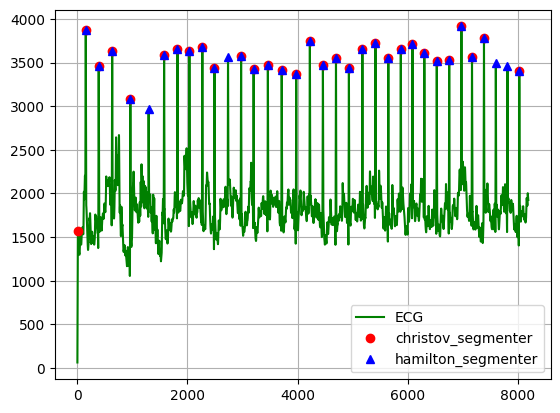

2023-05-04 21:22:57,971 - root - INFO - 完成.


In [21]:
# 绘波形图和R波位置
num_plot_samples = 1024*8
logging.info("绘制波形图和检测的R波位置 ...")
sig_plot = test_ECG[:num_plot_samples]
rpeaks_plot_1 = rpeaks_indices_1[rpeaks_indices_1 <= num_plot_samples]
plt.figure()
plt.plot(sig_plot, "g", label="ECG")
plt.grid(True)
plt.plot(rpeaks_plot_1, sig_plot[rpeaks_plot_1], "ro", label="christov_segmenter")
rpeaks_plot_3 = rpeaks_indices_2[rpeaks_indices_2 <= num_plot_samples]
plt.plot(rpeaks_plot_3, sig_plot[rpeaks_plot_3], "b^", label="hamilton_segmenter")
plt.legend()
plt.show()
logging.info("完成.")

### 计算心率

In [26]:
# API计算心率
heart_rate = 60 / (np.mean(np.diff(rpeaks)) / fs)
logging.info("平均心率: %.3f / 分钟." % (heart_rate))

2023-05-04 21:28:28,011 - root - INFO - 平均心率: 128.731 / 分钟.


In [28]:
win_before = 0.3625
win_after = 0.3625
logging.info("根据R波位置截取心拍, 心拍前窗口：%.3f 秒 ~ 心拍后窗口：%.3f 秒 ..." \
             % (win_before, win_after))
tic = time.time()
beats, rpeaks_beats = ecg.extract_heartbeats(test_ECG, rpeaks_indices_1, fs, win_before, win_after)
toc = time.time()
logging.info("完成. 用时: %f 秒." % (toc - tic))
logging.info("共截取到 %d 个心拍, 每个心拍长度为 %d 个采样点" % \
             (beats.shape[0], beats.shape[1]))

2023-05-04 21:31:07,085 - root - INFO - 根据R波位置截取心拍, 心拍前窗口：0.362 秒 ~ 心拍后窗口：0.362 秒 ...
2023-05-04 21:31:07,086 - root - INFO - 完成. 用时: 0.000000 秒.
2023-05-04 21:31:07,087 - root - INFO - 共截取到 28 个心拍, 每个心拍长度为 370 个采样点


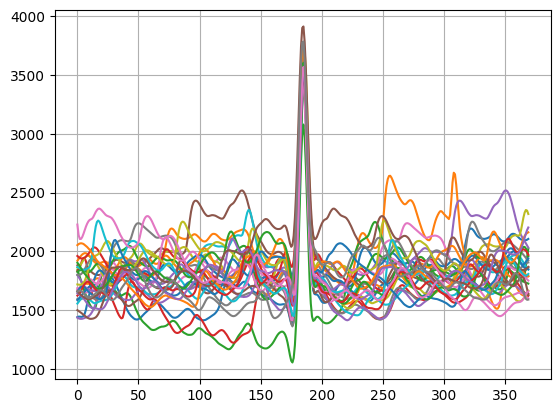

In [29]:
# 将所有心拍标记出来
plt.figure()
plt.grid(True)
for i in range(beats.shape[0]):
    plt.plot(beats[i])
plt.show()

### API自动检测

2023-05-05 15:47:38,876 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2023-05-05 15:47:38,877 - PIL.PngImagePlugin - DEBUG - STREAM b'sBIT' 41 4
2023-05-05 15:47:38,879 - PIL.PngImagePlugin - DEBUG - b'sBIT' 41 4 (unknown)
2023-05-05 15:47:38,880 - PIL.PngImagePlugin - DEBUG - STREAM b'pHYs' 57 9
2023-05-05 15:47:38,881 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 78 374
2023-05-05 15:47:38,896 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2023-05-05 15:47:38,900 - PIL.PngImagePlugin - DEBUG - STREAM b'sBIT' 41 4
2023-05-05 15:47:38,904 - PIL.PngImagePlugin - DEBUG - b'sBIT' 41 4 (unknown)
2023-05-05 15:47:38,909 - PIL.PngImagePlugin - DEBUG - STREAM b'pHYs' 57 9
2023-05-05 15:47:38,924 - PIL.PngImagePlugin - DEBUG - STREAM b'IDAT' 78 286
2023-05-05 15:47:38,932 - PIL.PngImagePlugin - DEBUG - STREAM b'IHDR' 16 13
2023-05-05 15:47:38,934 - PIL.PngImagePlugin - DEBUG - STREAM b'sBIT' 41 4
2023-05-05 15:47:38,935 - PIL.PngImagePlugin - DEBUG - b'sBIT' 41 4 (unknown)
2023-05-0

ReturnTuple(ts=array([0.00000000e+00, 1.95312500e-03, 3.90625000e-03, ...,
       1.59941406e+01, 1.59960938e+01, 1.59980469e+01]), filtered=array([  2.85905545, 259.53147072, 501.37833216, ...,  94.87019988,
        89.41556422,  85.99502713]), rpeaks=array([ 152,  387,  632,  962, 1294, 1575, 1818, 2034, 2270, 2490, 2737,
       2974, 3201, 3460, 3711, 3975, 4223, 4460, 4697, 4932, 5177, 5414,
       5648, 5875, 6087, 6302, 6528, 6754, 6976, 7168, 7385, 7601, 7813]), templates_ts=array([-2.00000000e-01, -1.98039216e-01, -1.96078431e-01, -1.94117647e-01,
       -1.92156863e-01, -1.90196078e-01, -1.88235294e-01, -1.86274510e-01,
       -1.84313725e-01, -1.82352941e-01, -1.80392157e-01, -1.78431373e-01,
       -1.76470588e-01, -1.74509804e-01, -1.72549020e-01, -1.70588235e-01,
       -1.68627451e-01, -1.66666667e-01, -1.64705882e-01, -1.62745098e-01,
       -1.60784314e-01, -1.58823529e-01, -1.56862745e-01, -1.54901961e-01,
       -1.52941176e-01, -1.50980392e-01, -1.49019608e-01, -1.47

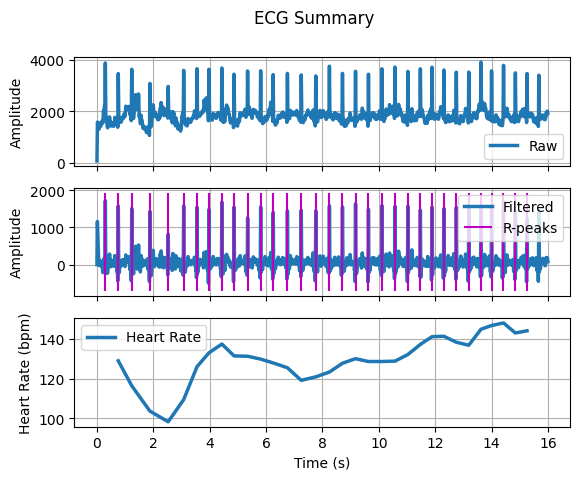

In [11]:
ecg.ecg(signal=test_ECG, sampling_rate=512, show=True)

### 对硬件过来的信号进行二分类

In [3]:
length = len(test_ECG)
ECG_Signal = np.empty(shape=[0,370])
for site in rpeaks_indices_2:
    if 185< site < length-185:
        ECG_signal = test_ECG.flatten().tolist()[site-185:site+185]
        ECG_Signal = np.row_stack((ECG_Signal,ECG_signal))

In [6]:
import scipy.io as scio
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
# 标准化
def standscaler_demo(date):
    transfer = StandardScaler()
    date1 = transfer.fit_transform(date)
    return date1

# 数据读进来处理的封装函数，只需要进行滤波操作和标准化操作
def ECG_process(ECG):
    ECG_filtered = np.zeros(ECG.shape)
    for line in range(0,ECG.shape[0]):
        ECG_filtered[line] = Wavelet_transform(ECG[line])
    ECG_standed = standscaler_demo(ECG_filtered)
    return ECG_filtered,ECG_standed   # 返回值为两个数组

ECG_filtered,ECG_standed = ECG_process(ECG_Signal) 

In [60]:
# 模型的加载和使用
with open("II. Classification(SVC)2.pickle","rb") as f:
    SVM_load = pickle.load(f)

y_pre_svc = SVM_load.predict(ECG_filtered)
print("预测值是：{}".format(y_pre_svc))

预测值是：[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


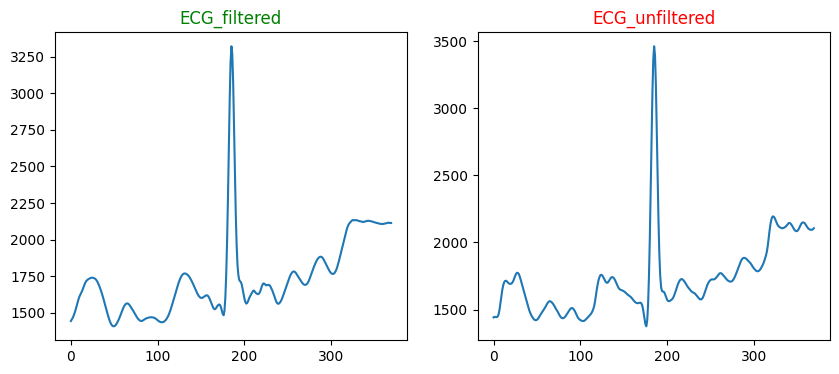

In [10]:
draw_num = int(input("请输入你想要绘制的ecg_filtered序号:"))
plt.figure(figsize = (10, 4))
plt.subplot(1,2,1)
plt.title("ECG_filtered",color="g")
plt.plot(ECG_filtered[draw_num])
plt.subplot(1,2,2)
plt.title("ECG_unfiltered",color="r")
plt.plot(ECG_Signal[draw_num])
plt.show()

In [ ]:
#### 这里可以将异常数据写入数据库

### 经过筛选的数据进入由MIT数据集训练的五分类模型

In [68]:
# 删掉预测为零的提取心电

for i in range(0,y_pre_svc.shape[0]):
    if y_pre_svc[i] == 0:
        ECG_filtered = np.delete(ECG_filtered[i],i,axis=0)
        # print(predict_array[i])
# signal

#### 下采样
##### 将512HZ数据重新采样为360HZ,以便模型更好的提取本地特征

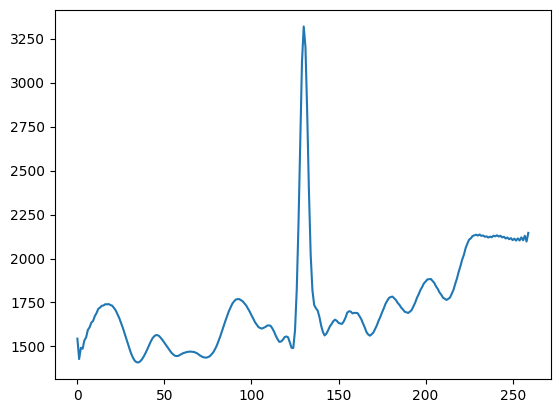

In [81]:
# 进行下采样370个点到260
from scipy import signal

def resample_ECG(ECG_filtered):
    # data1 = data / 4096 * 1.6 - 0.6
    resample_array = np.ones([ECG_filtered.shape[0],260])
    count = 0
    for i in ECG_filtered:
        # resample_list.append(scipy.signal.resample(i, 717, t=None, axis=0, window=None))
        resample_array[count] = signal.resample(i, 260, t=None, axis=0, window=None)
        count += 1
    return resample_array
resample_array = resample_ECG(ECG_filtered)
plt.plot(resample_ECG(ECG_filtered)[0])
plt.show()

#### 加载模型

In [82]:
# 0.9931
# tensorflow有毒,加载模型不能存放在中文路径下面
import tensorflow as tf

model = tf.keras.models.load_model('D:/VSproject/model/Five_classifications.h5')
model1 = model.predict(resample_array)

1/1 [==============================] - 0s 141ms/step


#### 五分类lableSet = ['F','N','Q','S','V']分别对应[0,1,2,3,4]

AAMI规定心电节拍可以分为五大类：
- N(正常或者束支传导阻滞节拍)
- s(室上性异常节拍)
- V(心室异常节拍)
- F(融合节拍)
- Q(未能分类的节拍)
以及无法识读的u类、辅助无法识读标志的x类和0类

In [90]:
from keras.utils import to_categorical

print('五分类预测的softmax输出:\n{}'.format(model1))
print("shape为:{}".format(model1.shape))
print('----------------------------------')
# 将其转化为onehot编码
one_hot_preds = to_categorical(model1.argmax(axis=1), num_classes=5)
print("onehot编码输出为:\n{}".format(one_hot_preds))
print("onehot输出的维度为:{}".format(one_hot_preds.shape))
print('----------------------------------')
# 再将onehot编码输出转化为直观的一维数组
data_pre = [np.argmax(one_hot)for one_hot in one_hot_preds]
print("最终分类为:{}".format(data_pre))




五分类预测的softmax输出:
[[8.40952463e-09 9.94997859e-01 6.92920679e-18 1.88705130e-07
  5.00186067e-03]
 [3.93304445e-10 9.98223722e-01 7.96623268e-20 3.84492331e-08
  1.77624437e-03]
 [4.25868230e-09 9.98067081e-01 1.92323484e-18 4.83940255e-07
  1.93246512e-03]
 [1.42907970e-06 9.64953721e-01 3.01221423e-13 5.37072219e-06
  3.50395143e-02]
 [3.33905015e-10 9.99890447e-01 6.76872255e-23 2.05179718e-09
  1.09493747e-04]
 [1.47212251e-08 9.95892525e-01 1.08164048e-17 1.89085668e-07
  4.10721032e-03]
 [2.87481838e-09 9.99117315e-01 3.98370984e-19 9.72438841e-08
  8.82551132e-04]
 [2.97704594e-09 9.95430350e-01 2.19540228e-18 9.29956983e-08
  4.56955004e-03]
 [2.30602981e-09 9.95872200e-01 1.97286422e-18 3.58634118e-08
  4.12782654e-03]
 [1.17852226e-08 9.95670915e-01 1.64850379e-17 2.57356618e-07
  4.32884460e-03]
 [3.00950092e-08 9.95541275e-01 3.83118858e-17 2.61857878e-07
  4.45843488e-03]
 [2.31043273e-08 9.97031212e-01 4.94051984e-17 4.32705519e-07
  2.96824682e-03]
 [3.53081973e-08 9.9610